In [2]:
! pip install lifelines --user
! pip install 'ray[default]'
! pip install 'ray[tune]'

import os
import pandas as pd
import numpy as np
import pickle
import time
from tqdm import tqdm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
import sklearn.linear_model as lm
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.tree import export_graphviz
from termcolor import colored
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
use_cuda = torch.cuda.is_available()

# Import pytorch_ehr
from importlib import reload
try:
    import sys
    sys.path.insert(0, "/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    import pytorch_ehr.models as model
    from pytorch_ehr.EHRDataloader import EHRdataloader
    from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
    import pytorch_ehr.utils_final as ut
    from pytorch_ehr.EHREmb import EHREmbeddings
except:
    print('Error: Ensure pytorch_ehr is available.')


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Error: Ensure pytorch_ehr is available.


In [9]:
from termcolor import colored
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
use_cuda = torch.cuda.is_available()
# Import pytorch_ehr
from importlib import reload
try:
    import sys
    sys.path.insert(0, "/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    import pytorch_ehr.models as model
    from pytorch_ehr.EHRDataloader import EHRdataloader
    from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
    import pytorch_ehr.utils_final as ut
    from pytorch_ehr.EHREmb import EHREmbeddings
except:
    print('Error: Ensure pytorch_ehr is available.')


Error: Ensure pytorch_ehr is available.


In [18]:
# Step 1: Install and Import Dependencies
! pip install lifelines --user
! pip install 'ray[default]'
! pip install 'ray[tune]'

import os
import pandas as pd
import numpy as np
import pickle
import time
from tqdm import tqdm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
import sklearn.linear_model as lm
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample  # For manual oversampling
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
use_cuda = torch.cuda.is_available()

# Step 2: Load and Preprocess Thyroid CSV into EHR Format
data = pd.read_csv('thyroid_data.csv')

# Drop unnecessary columns and handle missing values
data = data.drop(['S.no', 'On Thyroxine', 'Query on Thyroxine', 'On Antithyroid Medication', 'I131 Treatment', 'Query Hypothyroid', 'Query Hyperthyroid', 'Lithium', 'TSH Measured', 'Hypopituitary', 'Psych', 'T3 Measured', 'TT4 Measured', 'T4U Measured', 'FTI Measured'], axis=1)
data = data.replace('?', np.nan)
for col in ['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    data[col] = data[col].astype(float)
    data[col].fillna(data[col].median(), inplace=True)
data['Sex'].fillna(data['Sex'].mode()[0], inplace=True)

# One-hot encode categorical features
sex = pd.get_dummies(data['Sex'], drop_first=True)
sick = pd.get_dummies(data['Sick'], drop_first=True)
pregnant = pd.get_dummies(data['Pregnant'], drop_first=True)
thyroid_surgery = pd.get_dummies(data['Thyroid Surgery'], drop_first=True)
goitre = pd.get_dummies(data['Goitre'], drop_first=True)
tumor = pd.get_dummies(data['Tumor'], drop_first=True)
data = pd.concat([data, sex, sick, pregnant, thyroid_surgery, goitre, tumor], axis=1)
data.drop(['Sex', 'Sick', 'Pregnant', 'Thyroid Surgery', 'Goitre', 'Tumor'], axis=1, inplace=True)

# Map Category to Prescription Classes
prescription_mapping = {'negative': 0, 'hyperthyroid': 1, 'hypothyroid': 2, 'sick': 3}
data['Prescription'] = data['Category'].map(prescription_mapping)
data.drop('Category', axis=1, inplace=True)

# Balance the dataset manually
data_balanced_list = []
max_count = data['Prescription'].value_counts().max()
for class_label in data['Prescription'].unique():
    class_subset = data[data['Prescription'] == class_label]
    if len(class_subset) < max_count:
        oversampled = resample(class_subset, replace=True, n_samples=max_count, random_state=0)
        data_balanced_list.append(oversampled)
    else:
        data_balanced_list.append(class_subset)
data_balanced = pd.concat(data_balanced_list).reset_index(drop=True)

# Scale features for better model convergence
scaler = StandardScaler()
features = data_balanced.drop('Prescription', axis=1)
print(f"Features used for scaling: {list(features.columns)}")  # Should be 12: Age, TSH, T3, TT4, T4U, FTI, Sex_M, Sick_t, Pregnant_t, Thyroid Surgery_t, Goitre_t, Tumor_t
features_scaled = scaler.fit_transform(features)
data_balanced_scaled = pd.DataFrame(features_scaled, columns=features.columns)
data_balanced_scaled['Prescription'] = data_balanced['Prescription'].values

# Split data
train_data, test_data = train_test_split(data_balanced_scaled, test_size=0.2, random_state=0)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=0)

# Convert to tensors for PyTorch
def create_tensors(df, output_col='Prescription'):
    features = df.drop(output_col, axis=1).values.astype(np.float32)
    labels = df[output_col].values.astype(np.int64)
    # Each "sequence" is length 1: [batch_size, seq_len=1, input_size]
    features = torch.tensor(features).unsqueeze(1)  # Add seq_len diAmension
    labels = torch.tensor(labels)
    return features, labels

train_features, train_labels = create_tensors(train_data)
valid_features, valid_labels = create_tensors(valid_data)
test_features, test_labels = create_tensors(test_data)

# Step 3: Define and Train Custom GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

input_size = train_features.shape[2]  # Number of features (12)
hidden_size = 32
num_classes = 4
model = GRUModel(input_size, hidden_size, num_classes)
if use_cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()  # For multiclass
optimizer = optim.Adamax(model.parameters(), lr=0.1)

# Training loop
epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.cuda() if use_cuda else train_features)
    loss = criterion(outputs, train_labels.cuda() if use_cuda else train_labels)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(valid_features.cuda() if use_cuda else valid_features)
        val_loss = criterion(val_outputs, valid_labels.cuda() if use_cuda else valid_labels)
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gru_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Load best model
model.load_state_dict(torch.load('best_gru_model.pth'))

# Step 4: Evaluate the Model
model.eval()
with torch.no_grad():
    test_outputs = model(test_features.cuda() if use_cuda else test_features)
    _, predicted = torch.max(test_outputs, 1)
    print(classification_report(test_labels.numpy(), predicted.numpy()))

# Step 5: Hyperparameter Tuning (Basic Grid Search)
best_acc = 0
best_params = {}
for lr in [0.01, 0.1]:
    for hidden_size in [16, 32, 64]:
        model_temp = GRUModel(input_size, hidden_size, num_classes)
        if use_cuda:
            model_temp.cuda()
        optimizer_temp = optim.Adamax(model_temp.parameters(), lr=lr)
        # Quick training (5 epochs)
        for _ in range(5):
            model_temp.train()
            optimizer_temp.zero_grad()
            outputs = model_temp(train_features.cuda() if use_cuda else train_features)
            loss = criterion(outputs, train_labels.cuda() if use_cuda else train_labels)
            loss.backward()
            optimizer_temp.step()
        # Evaluate
        model_temp.eval()
        with torch.no_grad():
            test_outputs = model_temp(test_features.cuda() if use_cuda else test_features)
            _, predicted = torch.max(test_outputs, 1)
            acc = (predicted == test_labels.cuda() if use_cuda else test_labels).float().mean().item()
        if acc > best_acc:
            best_acc = acc
            best_params = {'lr': lr, 'hidden_size': hidden_size}
print(f"Best Params: {best_params}, Best Acc: {best_acc:.4f}")

# Step 6: Compare with Baseline (Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(data_balanced_scaled.drop('Prescription', axis=1), data_balanced_scaled['Prescription'], test_size=0.2, random_state=0)
EHR_LR = lm.LogisticRegression(multi_class='ovr', max_iter=1000)  # Increased max_iter
EHR_LR.fit(X_train, y_train)
y_pred = EHR_LR.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 7: Prediction Example
# Feature order: Age, TSH, T3, TT4, T4U, FTI, Sex_M, Sick_t, Pregnant_t, Thyroid Surgery_t, Goitre_t, Tumor_t
# Example: Age=41, TSH=1.3 (typical), T3=2.5, TT4=125, T4U=1.14, FTI=109, Sex_M=0, Sick_t=0, Pregnant_t=0, Thyroid Surgery_t=0, Goitre_t=0, Tumor_t=0
new_features = [[41, 1.3, 2.5, 125, 1.14, 109, 0, 0, 0, 0, 0, 0]]  # Now 12 features
new_features_scaled = scaler.transform(np.array(new_features))  # Scale
new_tensor = torch.tensor(new_features_scaled, dtype=torch.float32).unsqueeze(0)  # [1, 1, 12] - only one unsqueeze
model.eval()
with torch.no_grad():
    output = model(new_tensor.cuda() if use_cuda else new_tensor)
    _, predicted_class = torch.max(output, 1)
print(f"Predicted Prescription Class: {predicted_class.item()}")
# 0: No prescription, 1: Antithyroid, 2: Thyroid replacement, 3: Other



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Features used for scaling: ['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'M', 't', 't', 't', 't', 't']
Epoch 1/100, Train Loss: 1.4275, Val Loss: 1.0958
Epoch 2/100, Train Loss: 1.1114, Val Loss: 0.8758
Epoch 3/100, Train Loss: 0.9217, Val Loss: 0.7818
Epoch 4/100, Train Loss: 0.8377, Val Loss: 0.7508
Epoch 5/100, Train Loss: 0.8005, Val Loss: 0.7363
Epoch 6/100, Train Loss: 0.7728, Val Loss: 0.7236
Epoch 7/100, Train Loss: 0.7494, Val Loss: 0.7026
Epoch 8/100, Train Loss: 0.7234, Val Loss: 0.6793
Epoch 9/100, Train Loss: 0.6977, Val Loss: 0.6574
Epoch 10/100, Train Loss: 0.6735, Val Loss: 0.6389
Epoch 11/100, Train Loss: 0.6526, Val Loss: 0.6218
Epoch 12/100, Train Lo

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  


Epoch 1/100, Train Loss: 0.3163, Val Loss: 0.3120
Epoch 2/100, Train Loss: 0.3156, Val Loss: 0.3114
Epoch 3/100, Train Loss: 0.3150, Val Loss: 0.3108
Epoch 4/100, Train Loss: 0.3143, Val Loss: 0.3102
Epoch 5/100, Train Loss: 0.3137, Val Loss: 0.3096
Epoch 6/100, Train Loss: 0.3131, Val Loss: 0.3091
Epoch 7/100, Train Loss: 0.3125, Val Loss: 0.3085
Epoch 8/100, Train Loss: 0.3118, Val Loss: 0.3080
Epoch 9/100, Train Loss: 0.3112, Val Loss: 0.3075
Epoch 10/100, Train Loss: 0.3106, Val Loss: 0.3070
Epoch 11/100, Train Loss: 0.3100, Val Loss: 0.3065
Epoch 12/100, Train Loss: 0.3094, Val Loss: 0.3060
Epoch 13/100, Train Loss: 0.3088, Val Loss: 0.3055
Epoch 14/100, Train Loss: 0.3082, Val Loss: 0.3051
Epoch 15/100, Train Loss: 0.3077, Val Loss: 0.3047
Epoch 16/100, Train Loss: 0.3071, Val Loss: 0.3043
Epoch 17/100, Train Loss: 0.3065, Val Loss: 0.3039
Epoch 18/100, Train Loss: 0.3060, Val Loss: 0.3034
Epoch 19/100, Train Loss: 0.3054, Val Loss: 0.3029
Epoch 20/100, Train Loss: 0.3049, Val Lo

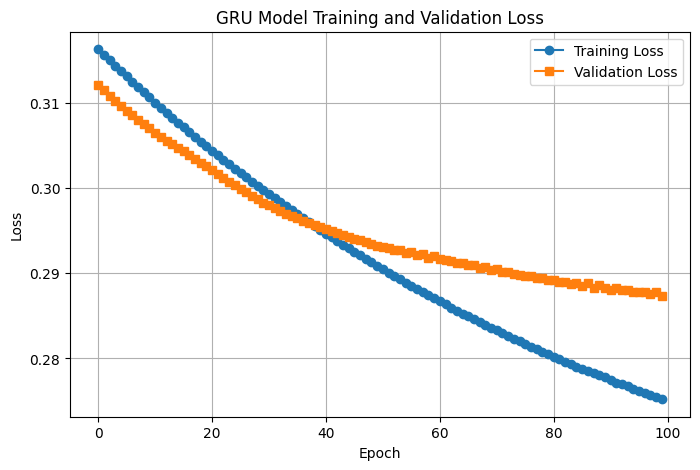

In [19]:
import matplotlib.pyplot as plt

# Track losses across epochs
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.cuda() if use_cuda else train_features)
    loss = criterion(outputs, train_labels.cuda() if use_cuda else train_labels)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(valid_features.cuda() if use_cuda else valid_features)
        val_loss = criterion(val_outputs, valid_labels.cuda() if use_cuda else valid_labels)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gru_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


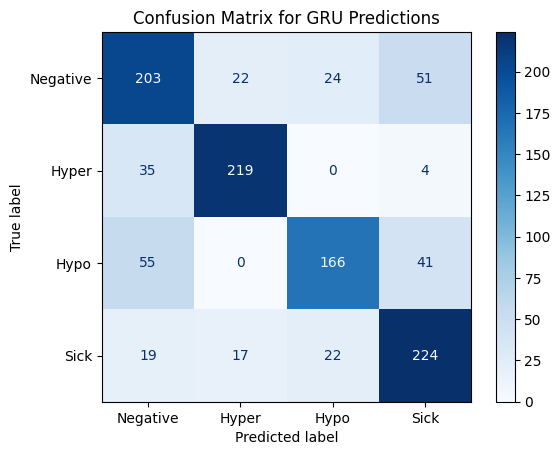

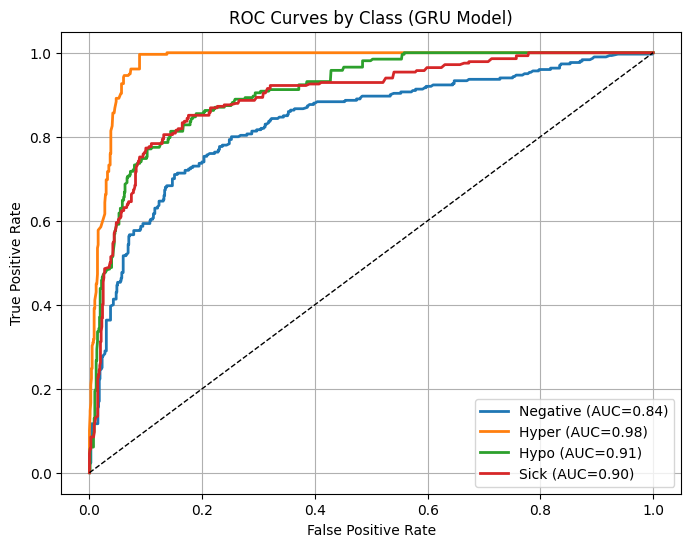

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(test_labels.numpy(), predicted.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Hyper', 'Hypo', 'Sick'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for GRU Predictions")
plt.show()

# ROC Curves (multiclass)
y_true_bin = pd.get_dummies(test_labels.numpy())
y_score = torch.softmax(test_outputs, dim=1).cpu().numpy()
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Negative', 'Hyper', 'Hypo', 'Sick']):
    fpr, tpr, _ = roc_curve(y_true_bin.iloc[:, i], y_score[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class (GRU Model)")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Batch test examples
example_patients = [
    # --- Normal / Negative Cases (expected class 0) ---
    [40, 1.2, 2.3, 110, 1.1, 105, 1, 0, 0, 0, 0, 0],  # healthy middle-aged male
    [32, 1.8, 2.6, 115, 1.2, 110, 0, 0, 0, 0, 0, 0],  # healthy female baseline
    [55, 1.0, 2.4, 100, 1.0, 100, 1, 0, 0, 0, 0, 0],  # older normal male

    # --- Hyperthyroid Cases (expected class 1) ---
    [30, 0.05, 3.7, 200, 1.4, 160, 0, 0, 0, 0, 0, 0],  # low TSH, high T3/T4
    [47, 0.1, 4.0, 180, 1.5, 170, 1, 0, 0, 0, 1, 0],   # goitre with suppressed TSH
    [25, 0.02, 3.8, 210, 1.6, 180, 0, 0, 0, 0, 0, 0],  # severe hyperthyroid levels

    # --- Hypothyroid Cases (expected class 2) ---
    [60, 8.7, 0.9, 60, 0.8, 70, 0, 0, 0, 0, 1, 0],     # classic hypothyroid + goitre
    [45, 10.2, 0.7, 50, 0.9, 55, 1, 0, 0, 0, 0, 0],    # severely elevated TSH
    [38, 6.0, 1.0, 70, 0.9, 65, 0, 0, 0, 1, 0, 0],     # post-thyroid surgery hypothyroid

    # --- Sick (Non-Thyroidal Illness Syndrome) Cases (expected class 3) ---
    [52, 0.7, 1.2, 95, 0.9, 85, 1, 1, 0, 0, 0, 0],     # systemic illness, altered labs
    [29, 1.0, 1.5, 100, 1.1, 95, 0, 1, 0, 0, 0, 0],    # mild suppression from sickness
    [48, 0.6, 1.1, 90, 1.0, 80, 1, 1, 0, 0, 0, 0],     # euthyroid-sick pattern
]

example_scaled = scaler.transform(example_patients)
example_tensor = torch.tensor(example_scaled, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    outputs = model(example_tensor.cuda() if use_cuda else example_tensor)
    _, preds = torch.max(outputs, 1)

for i, pred in enumerate(preds):
    print(f"Example {i+1}: Predicted Prescription Class → {pred.item()}")


Example 1: Predicted Prescription Class → 0
Example 2: Predicted Prescription Class → 0
Example 3: Predicted Prescription Class → 0
Example 4: Predicted Prescription Class → 0
Example 5: Predicted Prescription Class → 0
Example 6: Predicted Prescription Class → 0
Example 7: Predicted Prescription Class → 0
Example 8: Predicted Prescription Class → 2
Example 9: Predicted Prescription Class → 0
Example 10: Predicted Prescription Class → 3
Example 11: Predicted Prescription Class → 0
Example 12: Predicted Prescription Class → 3


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  


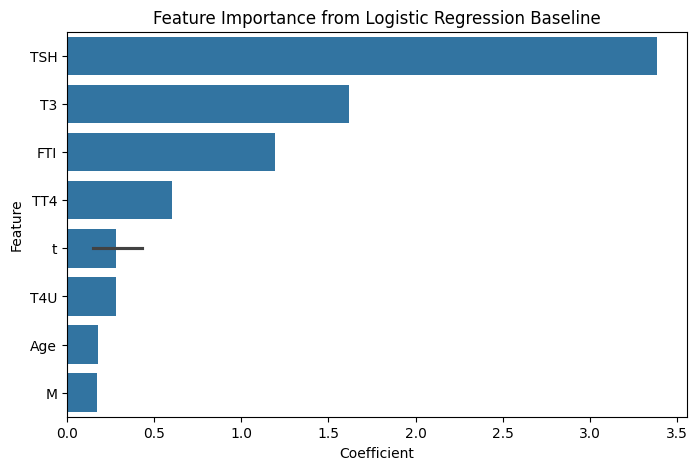

In [22]:
import seaborn as sns
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': np.mean(np.abs(EHR_LR.coef_), axis=0)
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance from Logistic Regression Baseline')
plt.show()


In [6]:
# Load the CSV
data = pd.read_csv('thyroid_data.csv')

# Drop unnecessary columns and handle missing values (as in the example)
data = data.drop(['S.no', 'On Thyroxine', 'Query on Thyroxine', 'On Antithyroid Medication', 'I131 Treatment', 'Query Hypothyroid', 'Query Hyperthyroid', 'Lithium', 'TSH Measured', 'Hypopituitary', 'Psych', 'T3 Measured', 'TT4 Measured', 'T4U Measured', 'FTI Measured'], axis=1)
data = data.replace('?', np.nan)
for col in ['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    data[col] = data[col].astype(float)
    data[col].fillna(data[col].median(), inplace=True)
data['Sex'].fillna(data['Sex'].mode()[0], inplace=True)

# One-hot encode categorical features
sex = pd.get_dummies(data['Sex'], drop_first=True)
sick = pd.get_dummies(data['Sick'], drop_first=True)
pregnant = pd.get_dummies(data['Pregnant'], drop_first=True)
thyroid_surgery = pd.get_dummies(data['Thyroid Surgery'], drop_first=True)
goitre = pd.get_dummies(data['Goitre'], drop_first=True)
tumor = pd.get_dummies(data['Tumor'], drop_first=True)
data = pd.concat([data, sex, sick, pregnant, thyroid_surgery, goitre, tumor], axis=1)
data.drop(['Sex', 'Sick', 'Pregnant', 'Thyroid Surgery', 'Goitre', 'Tumor'], axis=1, inplace=True)

# Map Category to Prescription Classes
prescription_mapping = {'negative': 0, 'hyperthyroid': 1, 'hypothyroid': 2, 'sick': 3}
data['Prescription'] = data['Category'].map(prescription_mapping)
data.drop('Category', axis=1, inplace=True)

# Balance the dataset (as in the example)
from imblearn.over_sampling import RandomOverSampler
X = data.drop('Prescription', axis=1)
y = data['Prescription']
rdsmple = RandomOverSampler()
X_sampled, y_sampled = rdsmple.fit_resample(X, y)
data_balanced = pd.concat([X_sampled, y_sampled], axis=1)

# Convert to EHR sequence format (each patient as a single-step sequence)
# Features: Age, TSH, T3, TT4, T4U, FTI, Sex_M, Sick_t, etc.
# Output: Prescription class
def create_ehr_sequences(df, output_col='Prescription'):
    sequences = []
    for _, row in df.iterrows():
        # Each sequence: [features at time 0], label
        features = row.drop(output_col).values.astype(float).tolist()
        label = int(row[output_col])
        # Simulate a sequence: [[features]] (length 1)
        seq = [[[features]]]  # Nested for EHR format: patient -> visits -> codes
        sequences.append([label, seq])  # [label, sequence]
    return sequences

train_data, test_data = train_test_split(data_balanced, test_size=0.2, random_state=0)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=0)

train_sl = create_ehr_sequences(train_data)
valid_sl = create_ehr_sequences(valid_data)
test_sl = create_ehr_sequences(test_data)

# Create types dictionary (map feature indices to types)
num_features = len(X.columns)
types_d = {i: f'feat_{i}' for i in range(num_features)}
types_d_rev = {v: k for k, v in types_d.items()}
input_size_l = [num_features]

# Save as pickles (for compatibility)
input_dir = '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data/'
data_prefix = '/thyroid_prescription'
pickle.dump(train_sl, open(input_dir + data_prefix + '.combined.train', 'wb'))
pickle.dump(test_sl, open(input_dir + data_prefix + '.combined.test', 'wb'))
pickle.dump(valid_sl, open(input_dir + data_prefix + '.combined.valid', 'wb'))
pickle.dump(types_d, open(input_dir + data_prefix + '.types', 'wb'))

print(len(train_sl), len(valid_sl), len(test_sl))
print(input_size_l)

ImportError: cannot import name 'EstimatorCheckFailedWarning' from 'sklearn.exceptions' (/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/exceptions.py)